## Windows Event Log Anomalies

In this notebook we will be using windows event logs to train a clustering model that will identify anomalous event code, user and host combinations in a given dataset.

***Stage 0: Import Libraries***
    
In this section we import all the python code libraries we will be using in the notebook

In [1]:
import io, os, sys, types, datetime, math, time, glob
from datetime import datetime, timedelta

import splunklib.client as client
import splunklib.results as results
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt 
%matplotlib inline

***Stage 1: Connect to and query Splunk***

Here we will initialise a connection to a Splunk instance and query some of the Boss of the SOC (BOTS) data - in this case the BOTSv2 dataset which can be found here: https://github.com/splunk/botsv2

In [2]:
HOST = "localhost"
PORT = 8089
USERNAME = "admin"
PASSWORD = "5up3rn0va"

# Create a Service instance and log in 
service = client.connect(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD)

In [3]:
# Run an export search and display the results using the results reader.
kwargs_export = {"earliest_time": "0",
                 "latest_time": "now",
                 "enable_lookups": "true",
                 "parse_only": "false",
                 "count": "0"}
searchquery_export = """search index=botsv2 source="*WinEventLog:Security" earliest=1503183600 latest=1504306800
        | bin _time span=1h
        | eval key=host."|".user."|".EventCode
        | stats count by _time key 
        | makemv key delim="|"
        | eval DayOfWeek=strftime(_time,"%a"), host=mvindex(key,0), user=mvindex(key,1), EventCode=mvindex(key,2)
        | eval key=mvjoin(key, "|")"""

exportsearch_results = service.jobs.oneshot(searchquery_export, **kwargs_export)

# Get the results and display them using the ResultsReader
reader = results.ResultsReader(exportsearch_results)

items=[]
for item in reader:
    items.append(item)

df=pd.DataFrame(items)

***Stage 2: Feature Engineering***

In this section we will be creating the features that we will be using to train our clustering model. 

Firt we are going to calculated a normalised Perlich ratio to convert our high cardinality categorical features into numeric data that a clustering algorithm can use.

In [4]:
def normalised_perlich_ratio(x,y,name):
    crosstab=pd.crosstab(x,y)
    xy = crosstab.divide(crosstab.sum(axis=1), axis=0)
    pr_denom = np.sqrt((xy ** 2).sum(axis=1))
    pr_matrix = xy.divide(pr_denom, axis=0)
    pr_normalised = pr_matrix.divide(pr_matrix.sum(axis=0), axis=1).transpose()
    
    list=[]
    for index, row in pr_normalised.iterrows():
        list.append([index,"Mon",row[1]])
        list.append([index,"Tue",row[5]])
        list.append([index,"Wed",row[6]])
        list.append([index,"Thu",row[4]])
        list.append([index,"Fri",row[0]])
        list.append([index,"Sat",row[2]])
        list.append([index,"Sun",row[3]])
    
    pr_normalised_list=pd.DataFrame(list,columns=[name,'DayOfWeek',name+'_ratio'])

    return pr_normalised_list

In [5]:
event_code_pr=normalised_perlich_ratio(df['DayOfWeek'],df['EventCode'],'EventCode')
host_pr=normalised_perlich_ratio(df['DayOfWeek'],df['host'],'host')
user_pr=normalised_perlich_ratio(df['DayOfWeek'],df['user'],'user')
key_pr=normalised_perlich_ratio(df['DayOfWeek'],df['key'],'key')

Next we enrich our original data with the Perlich ratios we have just calculated.

In [6]:
df = pd.merge(df, event_code_pr,  how='left', left_on=['EventCode','DayOfWeek'], right_on = ['EventCode','DayOfWeek'])
df = pd.merge(df, host_pr,  how='left', left_on=['host','DayOfWeek'], right_on = ['host','DayOfWeek'])
df = pd.merge(df, user_pr,  how='left', left_on=['user','DayOfWeek'], right_on = ['user','DayOfWeek'])
df = pd.merge(df, key_pr,  how='left', left_on=['key','DayOfWeek'], right_on = ['key','DayOfWeek'])

We are now going to scale the counts and the ratios, further normalising our original data.

In [7]:
scaler = StandardScaler()
scaler.fit(df[['count','EventCode_ratio','host_ratio','user_ratio','key_ratio']])

column_names=['scaled_count','scaled_EventCode_ratio','scaled_host_ratio','scaled_user_ratio','scaled_key_ratio']
scaled_data=pd.DataFrame(scaler.transform(df[['count','EventCode_ratio','host_ratio','user_ratio','key_ratio']]),columns=column_names)

With the scaled data we are going to using principal component analysis to reduce the dimensions from 5 down to 2. This is partly to reduce the risk of a few features biasing the clustering model and partly to help us visualise the results later on.

In [8]:
pca = PCA(n_components=2)
components=pca.fit_transform(scaled_data)
principal_df = pd.DataFrame(data = components, columns = ['PC_1', 'PC_2'])

***Stage 3: Fit the Clustering Model***

In this final section we will trian a clustering model using DBSCAN (https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556) before visualising our results to identify the anomalies in our data.

In [9]:
clustering = DBSCAN(eps=0.6, min_samples=20).fit(principal_df)
principal_df['cluster']=clustering.labels_
clusters=pd.DataFrame(clustering.labels_,columns=['cluster'])
clusters=clusters.cluster.unique()

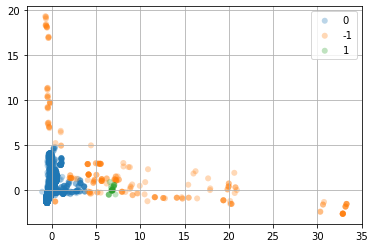

In [10]:
fig, ax = plt.subplots()
for cluster in clusters:
    
    ax.scatter(principal_df[principal_df.cluster==cluster]['PC_1'], principal_df[principal_df.cluster==cluster]['PC_2'], label=cluster,
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()